In [ ]:
import sys
from pathlib import Path

project_root = Path().cwd().parent.resolve().parent / 'src' / 'nanoCocoa_aiserver'
sys.path.insert(0, str(project_root))

print(str(project_root))


/home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [18]:
from helper_plot_hangul import matplotlib_font_reset
import matplotlib.pyplot as plt

In [11]:
import os
import logging
import torch
import logging
from helper_dev_utils import get_auto_logger
# ==========================================
# ⚙️ 설정 & 상수 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

# 예상 소요 시간 (초 단위, 초기값)
ESTIMATED_TIMES = {
    "init": 30,
    "stage_a": 300,  # 배경 생성 및 합성
    "stage_b": 200,  # 텍스트 자산 생성
    "stage_c": 90,   # 최종 합성 (Flux Inpainting 추가: 28 steps ≈ 30초)
}
TOTAL_ESTIMATED_TIME = sum(ESTIMATED_TIMES.values())

# 로깅 설정
logger = get_auto_logger()



2026-01-01 22:10:07 W [helper_utils_colab:211] - GoogleDrive not found, falling back to temp folder: /tmp
2026-01-01 22:10:07 W [helper_utils_colab:122] - Cache directory not found, falling back to temp folder: /tmp


In [30]:
def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [12]:
flush()
logger.debug("flush")

2026-01-01 22:15:33 D [ipykernel_launcher:2] - flush


In [ ]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import MODEL_IDS, DEVICE, logger
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(누끼 따기)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask




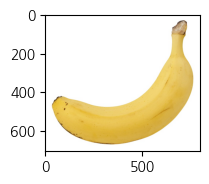

In [21]:
image_png = load_image("image.png").convert("RGB")
plt.figure(figsize=(2, 2))
plt.imshow(image_png)

2026-01-01 22:31:18 D [config:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


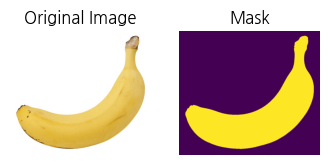

In [27]:
segmenter = SegmentationModel()
sm_result, sm_mask = segmenter.run(image_png)
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(image_png)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(sm_mask)
plt.title("Mask")
plt.axis("off")
plt.show()

In [46]:

import torch
import gc
from PIL import Image
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline,
    FluxInpaintPipeline,
    FluxTransformer2DModel
)
from transformers import BitsAndBytesConfig
from config import MODEL_IDS, TORCH_DTYPE, logger
from utils import flush_gpu

class FluxGenerator:
    """
    FLUX 모델을 사용하여 배경 생성, 이미지 리파인, 지능형 합성을 수행하는 클래스입니다.
    """
    def generate_background(self, prompt: str, negative_prompt: str = None, guidance_scale: float = 3.5, seed: int = None, progress_callback=None) -> Image.Image:
        """
        텍스트 프롬프트를 기반으로 배경 이미지를 생성합니다.
        
        Args:
            prompt (str): 배경 생성 프롬프트
            negative_prompt (str, optional): 배제할 요소들에 대한 부정 프롬프트
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 생성된 이미지
        """
        print("[Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)")
        flush_gpu()
        
        quant_config = BitsAndBytesConfig(load_in_4bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42) # Default seed for consistency if not specified

        num_steps = 25
        
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            logger.debug(f"[FluxGenerator] {step_index}/{num_steps} {timestep}")
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_generation")
            return callback_kwargs
        
        logger.debug(f"[FluxGenerator] {prompt}")
        logger.debug(f"[FluxGenerator] {negative_prompt}")
        image = pipe(
            prompt, negative_prompt=negative_prompt, height=1024, width=1024, 
            num_inference_steps=num_steps, guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]
        
        del pipe, transformer
        flush_gpu()
        return image

    def refine_image(self, draft_image: Image.Image, prompt: str = None, negative_prompt: str = None, strength: float = 0.6, guidance_scale: float = 3.5, seed: int = None, progress_callback=None) -> Image.Image:
        """
        이미지를 리터칭(Img2Img, 배경 합성)하여 품질을 높입니다.
        
        Args:
            draft_image (Image.Image): 초안 이미지
            prompt (str): 배경 합성 프롬프트 (없을 경우 기본값 사용)
            negative_prompt (str): 배경 합성 부정 프롬프트 (없을 경우 기본값 사용)
            strength (float): 변환 강도
            guidance_scale (float): 프롬프트 준수 강도
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백 함수
            
        Returns:
            Image.Image: 리터칭된 배경 합성 이미지
        """
        print("[Engine] Loading FLUX (Img-to-Img for Background Composition)... (FLUX 배경 합성 모델 로딩 중)")
        flush_gpu()
        
        quant_config = BitsAndBytesConfig(load_in_8bit=True)
        transformer = FluxTransformer2DModel.from_pretrained(
            MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
        )
        pipe = FluxImg2ImgPipeline.from_pretrained(
            MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
        )
        pipe.enable_model_cpu_offload()

        default_prompt = (
            "A photorealistic close-up shot of a product lying naturally on a surface. "
            "Heavy contact shadows, ambient occlusion, texture reflection, "
            "warm sunlight, cinematic lighting, 8k, extremely detailed."
        )
        use_prompt = prompt if prompt else default_prompt
        
        default_negative = "floating, disconnected, unrealistic shadows, artificial lighting, cut out, sticker effect"
        use_negative = negative_prompt if negative_prompt else default_negative

        generator = None
        if seed is not None:
             generator = torch.Generator("cpu").manual_seed(seed)
        else:
             generator = torch.Generator("cpu").manual_seed(42)

        num_steps = 30
        
        def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
            if progress_callback:
                progress_callback(step_index + 1, num_steps, "flux_bg_composition_refinement")
            return callback_kwargs

        refined_image = pipe(
            use_prompt,
            negative_prompt=use_negative,
            image=draft_image, 
            strength=strength, 
            num_inference_steps=num_steps, 
            guidance_scale=guidance_scale,
            generator=generator,
            callback_on_step_end=callback_fn if progress_callback else None
        ).images[0]

        del pipe, transformer
        flush_gpu()
        return refined_image

    def inject_features_via_inpaint(
        self,
        background: Image.Image,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        position: tuple,
        prompt: str,
        negative_prompt: str = None,
        strength: float = 0.5,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting을 사용하여 상품의 특성을 배경에 주입합니다.
        
        프로세스:
        1. 배경 이미지에 상품 위치 마스킹
        2. 상품 영역에 Inpainting으로 특성 주입
        3. 결과: 상품이 배경과 자연스럽게 통합된 이미지
        
        Args:
            background (Image.Image): 배경 이미지
            product_foreground (Image.Image): 상품 이미지 (투명 배경, RGBA)
            product_mask (Image.Image): 상품 마스크 (L 모드, 255=상품 영역)
            position (tuple): 상품 배치 위치 (x, y)
            prompt (str): 특성 주입 프롬프트
            negative_prompt (str, optional): 부정 프롬프트
            strength (float): Inpainting 강도 (0.0~1.0)
            guidance_scale (float): 프롬프트 준수 강도
            num_inference_steps (int): 추론 스텝 수
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백
            
        Returns:
            Image.Image: 특성이 주입된 최종 이미지
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting for feature injection...")
        flush_gpu()
        
        try:
            # Flux Inpainting 파이프라인 로드
            quant_config = BitsAndBytesConfig(load_in_8bit=True)
            transformer = FluxTransformer2DModel.from_pretrained(
                MODEL_IDS["FLUX"], 
                subfolder="transformer", 
                quantization_config=quant_config, 
                torch_dtype=TORCH_DTYPE
            )
            pipe = FluxInpaintPipeline.from_pretrained(
                MODEL_IDS["FLUX"], 
                transformer=transformer, 
                torch_dtype=TORCH_DTYPE
            )
            pipe.enable_model_cpu_offload()
            
            # 초안 이미지 생성 (상품을 배경에 임시 배치)
            draft = background.copy().convert("RGBA")
            draft.paste(product_foreground, position, product_foreground)
            draft_rgb = draft.convert("RGB")
            
            # Generator 설정
            generator = None
            if seed is not None:
                generator = torch.Generator("cpu").manual_seed(seed)
            else:
                generator = torch.Generator("cpu").manual_seed(42)
            
            # Progress callback
            def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
                if progress_callback:
                    progress_callback(step_index + 1, num_inference_steps, "flux_feature_injection")
                return callback_kwargs
            
            logger.info(f"[FluxGenerator] Injecting features: prompt='{prompt[:50]}...', strength={strength}")
            
            # Inpainting 실행 (상품 영역만 재생성하여 특성 주입)
            result = pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                image=draft_rgb,
                mask_image=product_mask,
                strength=strength,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                generator=generator,
                callback_on_step_end=callback_fn if progress_callback else None
            ).images[0]
            
            logger.info("[FluxGenerator] ✅ Feature injection completed")
            
            del pipe, transformer
            flush_gpu()
            
            return result
            
        except Exception as e:
            logger.error(f"[FluxGenerator] Feature injection failed: {e}", exc_info=True)
            flush_gpu()
            raise

    def inpaint_composite(
        self,
        background: Image.Image,
        text_asset: Image.Image,
        mask: Image.Image,
        prompt: str,
        strength: float = 0.4,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 28,
        seed: int = None,
        progress_callback=None
    ) -> Image.Image:
        """
        Flux Inpainting을 사용하여 텍스트를 배경과 맥락적으로 합성합니다.
        
        Args:
            background (Image.Image): 배경 이미지
            text_asset (Image.Image): 텍스트 에셋 (RGBA)
            mask (Image.Image): 합성 영역 마스크 (255=인페인팅, 0=보존)
            prompt (str): 합성 프롬프트
            strength (float): 변환 강도 (0.0~1.0)
            guidance_scale (float): 프롬프트 준수 강도
            num_inference_steps (int): 추론 스텝 수 (품질 우선: 28~50)
            seed (int, optional): 난수 시드
            progress_callback (callable, optional): 진행률 콜백
            
        Returns:
            Image.Image: 합성된 최종 이미지
        """
        logger.info("[FluxGenerator] Loading FLUX Inpainting for composition...")
        flush_gpu()
        
        try:
            # Flux Inpainting 파이프라인 로드
            quant_config = BitsAndBytesConfig(load_in_8bit=True)
            transformer = FluxTransformer2DModel.from_pretrained(
                MODEL_IDS["FLUX"], 
                subfolder="transformer", 
                quantization_config=quant_config, 
                torch_dtype=TORCH_DTYPE
            )
            pipe = FluxInpaintPipeline.from_pretrained(
                MODEL_IDS["FLUX"], 
                transformer=transformer, 
                torch_dtype=TORCH_DTYPE
            )
            pipe.enable_model_cpu_offload()
            
            # 초안 합성 (텍스트를 배경에 배치)
            draft = background.copy().convert("RGBA")
            text_resized = text_asset.resize(draft.size, Image.LANCZOS)
            draft.paste(text_resized, (0, 0), text_resized)
            draft_rgb = draft.convert("RGB")
            
            # Generator 설정
            generator = None
            if seed is not None:
                generator = torch.Generator("cpu").manual_seed(seed)
            else:
                generator = torch.Generator("cpu").manual_seed(42)
            
            # Progress callback
            def callback_fn(pipe_obj, step_index, timestep, callback_kwargs):
                if progress_callback:
                    progress_callback(step_index + 1, num_inference_steps, "flux_inpaint_composite")
                return callback_kwargs
            
            logger.info(f"[FluxGenerator] Running inpainting: prompt='{prompt[:50]}...', steps={num_inference_steps}")
            
            # Inpainting 실행
            result = pipe(
                prompt=prompt,
                image=draft_rgb,
                mask_image=mask,
                strength=strength,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                generator=generator,
                callback_on_step_end=callback_fn if progress_callback else None
            ).images[0]
            
            logger.info("[FluxGenerator] ✅ Inpainting composition completed")
            
            del pipe, transformer
            flush_gpu()
            
            return result
            
        except Exception as e:
            logger.error(f"[FluxGenerator] Inpainting failed: {e}", exc_info=True)
            flush_gpu()
            raise



In [47]:
flux_gen = FluxGenerator()

In [48]:
num_steps = 1

def progress_callback(step, total, sub_step_name):
    logger.debug(f"[Test Progress] {sub_step_name}: {step}/{total}")


guidance_scale의 값의 범위와 FLUX 모델에서의 권장 설정에 대해 설명해 드릴게요.

1. 기술적인 범위
최소값: 1.0 (사실상 프롬프트의 영향력을 거의 주지 않음)
최대값: 이론상 제한은 없으나, 20.0을 넘어가면 이미지가 심각하게 깨지기 시작합니다.

2. FLUX 모델에서의 권장 범위 (중요)
Stable Diffusion 같은 이전 모델들은 보통 7.0 ~ 9.0을 많이 썼지만, FLUX 모델은 훨씬 낮은 값을 사용하는 것이 특징입니다.
권장 범위: 2.0 ~ 5.0
현재 코드의 기본값: 3.5 (가장 안정적이고 품질이 좋은 표준값)

3. 값에 따른 변화
값 (Scale)	특징	결과물 느낌
1.0 ~ 1.5	프롬프트를 느슨하게 따름	몽환적이고 부드럽지만, 요청한 내용이 덜 반영될 수 있음
2.0 ~ 5.0	(권장) 균형 잡힌 설정	프롬프트를 잘 따르면서 자연스럽고 사실적인 이미지 생성
5.0 ~ 10.0	프롬프트를 강하게 따름	선명도가 높아지지만, 색감이 너무 진해지거나(채도 과포화) 인위적인 느낌이 들 수 있음
10.0 이상	과도한 강제	이미지가 '타버린' 것처럼 보이거나(노이즈 발생), 기괴하게 왜곡될 확률이 매우 높음
결론적으로: 현재 사용 중인 FLUX 모델에서는 2.0에서 5.0 사이로 조절하는 것이 가장 좋으며, 특별한 이유가 없다면 코드에 설정된 3.5를 그대로 유지하시는 것을 추천합니다.

In [52]:

flush()

prompt = "A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k."
negative_prompt = "banana, fruit, food, blurry, low quality, artificial, plastic, smooth surface, new wood, oversaturated, bad lighting"
background = flux_gen.generate_background(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    guidance_scale=3.5,
    seed=42,
    progress_callback=progress_callback,
)

flush()
logger.debug("Background generated")

[Engine] Loading FLUX (Text-to-Image)... (FLUX 텍스트-이미지 모델 로딩 중)


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


2026-01-01 23:32:55 D [config:58] - [FluxGenerator] A cinematic photograph of an aged, empty wooden farm table resting in a sunlit room. Shafts of warm sunlight stream across the rough tabletop, revealing dust motes and deep textures. The wood is weathered and dark. Shallow depth of field, highly detailed, rustic atmosphere, photorealistic, 8k.
2026-01-01 23:32:55 D [config:59] - [FluxGenerator] banana, fruit, food, blurry, low quality, artificial, plastic, smooth surface, new wood, oversaturated, bad lighting


  0%|          | 0/25 [00:00<?, ?it/s]

2026-01-01 23:36:40 D [config:53] - [FluxGenerator] 0/25 1000.0
2026-01-01 23:36:40 D [config:4] - [Test Progress] flux_bg_generation: 1/25


  4%|▍         | 1/25 [03:00<1:12:12, 180.52s/it]

2026-01-01 23:36:48 D [config:53] - [FluxGenerator] 1/25 986.9785766601562
2026-01-01 23:36:48 D [config:4] - [Test Progress] flux_bg_generation: 2/25


  8%|▊         | 2/25 [03:08<30:12, 78.82s/it]   

2026-01-01 23:36:55 D [config:53] - [FluxGenerator] 2/25 973.2041625976562
2026-01-01 23:36:55 D [config:4] - [Test Progress] flux_bg_generation: 3/25


 12%|█▏        | 3/25 [03:15<16:59, 46.35s/it]

2026-01-01 23:37:03 D [config:53] - [FluxGenerator] 3/25 958.609375
2026-01-01 23:37:03 D [config:4] - [Test Progress] flux_bg_generation: 4/25


 16%|█▌        | 4/25 [03:23<10:53, 31.12s/it]

2026-01-01 23:37:11 D [config:53] - [FluxGenerator] 4/25 943.1188354492188
2026-01-01 23:37:11 D [config:4] - [Test Progress] flux_bg_generation: 5/25


 20%|██        | 5/25 [03:31<07:34, 22.74s/it]

2026-01-01 23:37:19 D [config:53] - [FluxGenerator] 5/25 926.6473388671875
2026-01-01 23:37:19 D [config:4] - [Test Progress] flux_bg_generation: 6/25


 24%|██▍       | 6/25 [03:39<05:35, 17.68s/it]

2026-01-01 23:37:27 D [config:53] - [FluxGenerator] 6/25 909.0986938476562
2026-01-01 23:37:27 D [config:4] - [Test Progress] flux_bg_generation: 7/25


 28%|██▊       | 7/25 [03:47<04:20, 14.46s/it]

2026-01-01 23:37:35 D [config:53] - [FluxGenerator] 7/25 890.3637084960938
2026-01-01 23:37:35 D [config:4] - [Test Progress] flux_bg_generation: 8/25


 32%|███▏      | 8/25 [03:54<03:29, 12.33s/it]

2026-01-01 23:37:42 D [config:53] - [FluxGenerator] 8/25 870.3178100585938
2026-01-01 23:37:42 D [config:4] - [Test Progress] flux_bg_generation: 9/25


 36%|███▌      | 9/25 [04:02<02:54, 10.89s/it]

2026-01-01 23:37:50 D [config:53] - [FluxGenerator] 9/25 848.8184814453125
2026-01-01 23:37:50 D [config:4] - [Test Progress] flux_bg_generation: 10/25


 40%|████      | 10/25 [04:10<02:28,  9.89s/it]

2026-01-01 23:37:58 D [config:53] - [FluxGenerator] 10/25 825.70166015625
2026-01-01 23:37:58 D [config:4] - [Test Progress] flux_bg_generation: 11/25


 44%|████▍     | 11/25 [04:17<02:08,  9.19s/it]

2026-01-01 23:38:05 D [config:53] - [FluxGenerator] 11/25 800.7776489257812
2026-01-01 23:38:05 D [config:4] - [Test Progress] flux_bg_generation: 12/25


 48%|████▊     | 12/25 [04:25<01:53,  8.71s/it]

2026-01-01 23:38:13 D [config:53] - [FluxGenerator] 12/25 773.8260498046875
2026-01-01 23:38:13 D [config:4] - [Test Progress] flux_bg_generation: 13/25


 52%|█████▏    | 13/25 [04:33<01:40,  8.37s/it]

2026-01-01 23:38:20 D [config:53] - [FluxGenerator] 13/25 744.5887451171875
2026-01-01 23:38:20 D [config:4] - [Test Progress] flux_bg_generation: 14/25


 56%|█████▌    | 14/25 [04:40<01:29,  8.13s/it]

2026-01-01 23:38:28 D [config:53] - [FluxGenerator] 14/25 712.7622680664062
2026-01-01 23:38:28 D [config:4] - [Test Progress] flux_bg_generation: 15/25


 60%|██████    | 15/25 [04:48<01:19,  7.98s/it]

2026-01-01 23:38:36 D [config:53] - [FluxGenerator] 15/25 677.9867553710938
2026-01-01 23:38:36 D [config:4] - [Test Progress] flux_bg_generation: 16/25


 64%|██████▍   | 16/25 [04:55<01:10,  7.88s/it]

2026-01-01 23:38:43 D [config:53] - [FluxGenerator] 16/25 639.8322143554688
2026-01-01 23:38:43 D [config:4] - [Test Progress] flux_bg_generation: 17/25


 68%|██████▊   | 17/25 [05:03<01:02,  7.82s/it]

2026-01-01 23:38:51 D [config:53] - [FluxGenerator] 17/25 597.7811279296875
2026-01-01 23:38:51 D [config:4] - [Test Progress] flux_bg_generation: 18/25


 72%|███████▏  | 18/25 [05:11<00:54,  7.78s/it]

2026-01-01 23:38:59 D [config:53] - [FluxGenerator] 18/25 551.2044677734375
2026-01-01 23:38:59 D [config:4] - [Test Progress] flux_bg_generation: 19/25


 76%|███████▌  | 19/25 [05:19<00:46,  7.76s/it]

2026-01-01 23:39:06 D [config:53] - [FluxGenerator] 19/25 499.3301086425781
2026-01-01 23:39:06 D [config:4] - [Test Progress] flux_bg_generation: 20/25


 80%|████████  | 20/25 [05:26<00:38,  7.75s/it]

2026-01-01 23:39:14 D [config:53] - [FluxGenerator] 20/25 441.1997375488281
2026-01-01 23:39:14 D [config:4] - [Test Progress] flux_bg_generation: 21/25


 84%|████████▍ | 21/25 [05:34<00:30,  7.73s/it]

2026-01-01 23:39:22 D [config:53] - [FluxGenerator] 21/25 375.6090087890625
2026-01-01 23:39:22 D [config:4] - [Test Progress] flux_bg_generation: 22/25


 88%|████████▊ | 22/25 [05:42<00:23,  7.72s/it]

2026-01-01 23:39:29 D [config:53] - [FluxGenerator] 22/25 301.023193359375
2026-01-01 23:39:29 D [config:4] - [Test Progress] flux_bg_generation: 23/25


 92%|█████████▏| 23/25 [05:49<00:15,  7.71s/it]

2026-01-01 23:39:37 D [config:53] - [FluxGenerator] 23/25 215.455810546875
2026-01-01 23:39:37 D [config:4] - [Test Progress] flux_bg_generation: 24/25


 96%|█████████▌| 24/25 [05:57<00:07,  7.69s/it]

2026-01-01 23:39:45 D [config:53] - [FluxGenerator] 24/25 116.28876495361328
2026-01-01 23:39:45 D [config:4] - [Test Progress] flux_bg_generation: 25/25


100%|██████████| 25/25 [06:05<00:00, 14.61s/it]


2026-01-01 23:40:18 D [config:14] - Background generated


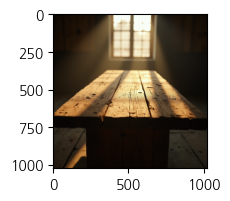

In [53]:
plt.figure(figsize=(2, 2))
plt.imshow(background)

In [ ]:

# flush()

# prompt = "A photorealistic close-up shot of a ripe yellow banana lying naturally on a rustic wooden table., Heavy contact shadows, ambient occlusion, wood texture reflection, warm sunlight, cinematic lighting, 8k, extremely detailed."
# negative_prompt = "blurry, low quality, distorted, ugly, bad lighting, overexposed, underexposed, artificial, plastic"
# background = flux_gen.generate_background(
#     prompt=prompt, 
#     negative_prompt=negative_prompt,
#     guidance_scale=3.5,
#     seed=42,
#     progress_callback=progress_callback,
# )

# flush()
# logger.debug("Background generated")